Model Name: distilbert-base-uncased

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('../CSV/Data/preped_data.csv')
labels = pd.read_csv('../CSV/Data/labels.csv')

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased")

In [7]:
def generate_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

In [8]:
#7 min to run

data['d_embedding'] = data['description'].apply(lambda x: generate_embeddings(x) if isinstance(x, str) else None)
data['b_embedding'] = data['business_tags'].apply(lambda x: generate_embeddings(x) if isinstance(x, str) else None)
labels['l_embedding'] = labels['label'].apply(lambda x: generate_embeddings(x) if isinstance(x, str) else None)

In [9]:
description_similarity = []
business_tags_similarity = []

In [10]:
for i in range(data.shape[0]):
    if data['d_embedding'][i] is not None:
        description_similarity.append(cosine_similarity([data['d_embedding'][i]], labels['l_embedding'].tolist())[0])
    else:
        description_similarity.append([0] * len(labels))
    if data['b_embedding'][i] is not None:
        business_tags_similarity.append(cosine_similarity([data['b_embedding'][i]], labels['l_embedding'].tolist())[0])
    else:
        business_tags_similarity.append([0] * len(labels))

In [11]:
similarities = (np.array(description_similarity) + np.array(business_tags_similarity))/2

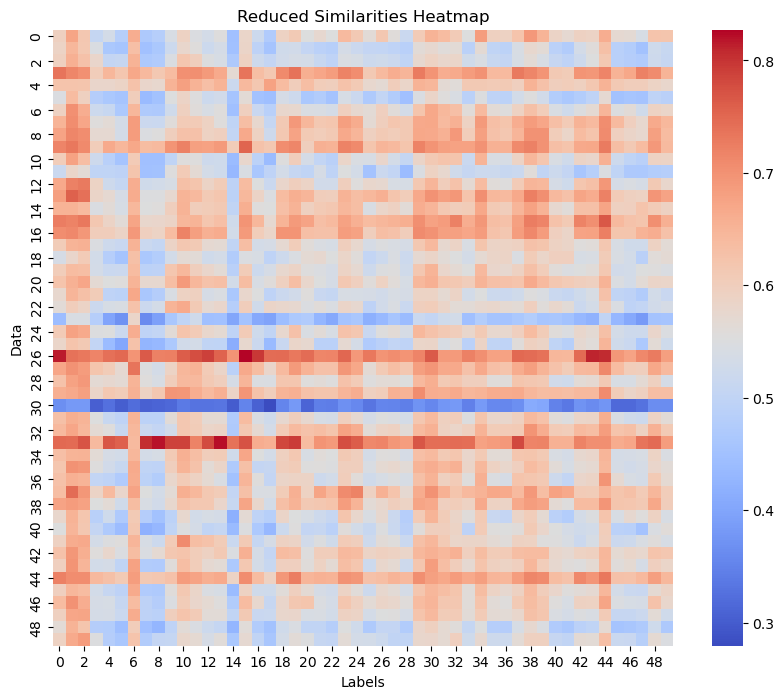

In [12]:
reduced_similarities = similarities[:50, :50] 

plt.figure(figsize=(10, 8))
sns.heatmap(reduced_similarities, cmap='coolwarm', cbar=True)
plt.title("Reduced Similarities Heatmap")
plt.xlabel("Labels")
plt.ylabel("Data")
plt.show()

In [13]:
def get_top_labels(similarities, labels, top_n=3):
    top_indices = np.argsort(similarities, axis=1)[:, -top_n:][:, ::-1]
    top_labels_with_scores = [[(labels[i], similarities[row_idx, i]) for i in indices] for row_idx, indices in enumerate(top_indices)]
    return top_labels_with_scores

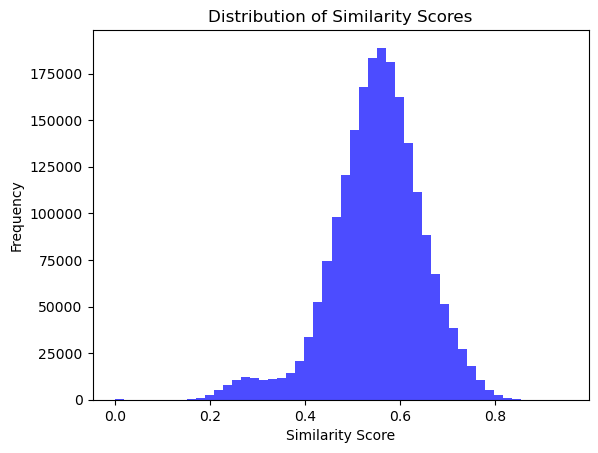

In [14]:
flattened_similarities = similarities.flatten()
plt.hist(flattened_similarities, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Similarity Scores")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.show()

In [15]:
similarities_array = np.vstack(similarities[:data.shape[0]])


In [16]:
data['top_labels'] = get_top_labels(similarities_array, labels['label'].tolist(), top_n=3)

In [ ]:
data[['description', 'business_tags', 'top_labels']].to_csv('../CSV/Tries/labelled_data_distilbert.csv', index=False)